In [1]:
try:
  import google.colab
  _isColab = True
except:
  _isColab = False
print('You are on Colab: ', _isColab)

You are on Colab:  False


In [2]:
if _isColab:
    %pip install monai nilearn

In [3]:
import os, sys, random
from sys import platform
if _isColab:
    _base_path = '/content'
else:
    _base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(os.path.join(_base_path, 'src'))
from monai.config import print_config
from monai.data import CacheDataset
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
from utils import make_dataset, make_dataset_on_colab, get_device, get_brats_classes
from plotting import plot_input_output, plot_training_values, plot_prediction
from training import train_test_splitting, training_model, predict_model
from config import get_config
from models import SegResNet
_config = get_config()
print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.3.0.dev20240314
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.2.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0.dev20240314
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.30.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about i

In [4]:
set_determinism(seed=3)
random.seed(3)

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
	"""
	Convert labels to multi channels based on BraTS-2023 classes.
	(See src.utils.get_brats_classes)
	"""
	def __call__(self, data):
		d = dict(data)
		for key in self.keys:
			d[key] = get_brats_classes(d[key])
		return d

In [6]:
train_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image', 'label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'), #(Left, Right),(Posterior, Anterior),(Inferior, Superior)
        Spacingd(
            keys=['image', 'label'],
            pixdim=(1.0, 1.0, 1.0),
            mode=('bilinear', 'nearest'),
        ),
        RandSpatialCropd(keys=['image', 'label'], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=1),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys='image', factors=0.1, prob=1.0),
        RandShiftIntensityd(keys='image', offsets=0.1, prob=1.0),
    ]
)
eval_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image', 'label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(
            keys=['image', 'label'],
            pixdim=(1.0, 1.0, 1.0),
            mode=('bilinear', 'nearest'),
        ),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ]
)
test_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image'], axcodes='RAS'),
        Spacingd(
			keys=['image'],
			pixdim=(1.0, 1.0, 1.0),
			mode='bilinear'
		),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ]
)
post_test_transforms = Compose(
    [
        Invertd(
            keys='pred',
            transform=test_transform,
            orig_keys='image',
            meta_keys='pred_meta_dict',
            orig_meta_keys='image_meta_dict',
            meta_key_postfix='meta_dict',
            nearest_interp=False,
            to_tensor=True,
            device='cpu',
        ),
        Activationsd(keys='pred', sigmoid=True),
        AsDiscreted(keys='pred', threshold=0.5),
    ]
)
post_trans = Compose(
	[
		Activations(sigmoid=True),
		AsDiscrete(threshold=0.5)
	]
)

In [7]:
data_path = make_dataset_on_colab('glioma', False) if _isColab else make_dataset('glioma', False)
train_data, eval_data, test_data = train_test_splitting(data_path)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            724 (64.0 %)        182 (16.0 %)        227 (20.0 %)        

sessions            795 (63.55 %)       197 (15.75 %)       259 (20.7 %)        



Input image shape: torch.Size([4, 224, 224, 144])
Input label shape: torch.Size([3, 224, 224, 144])


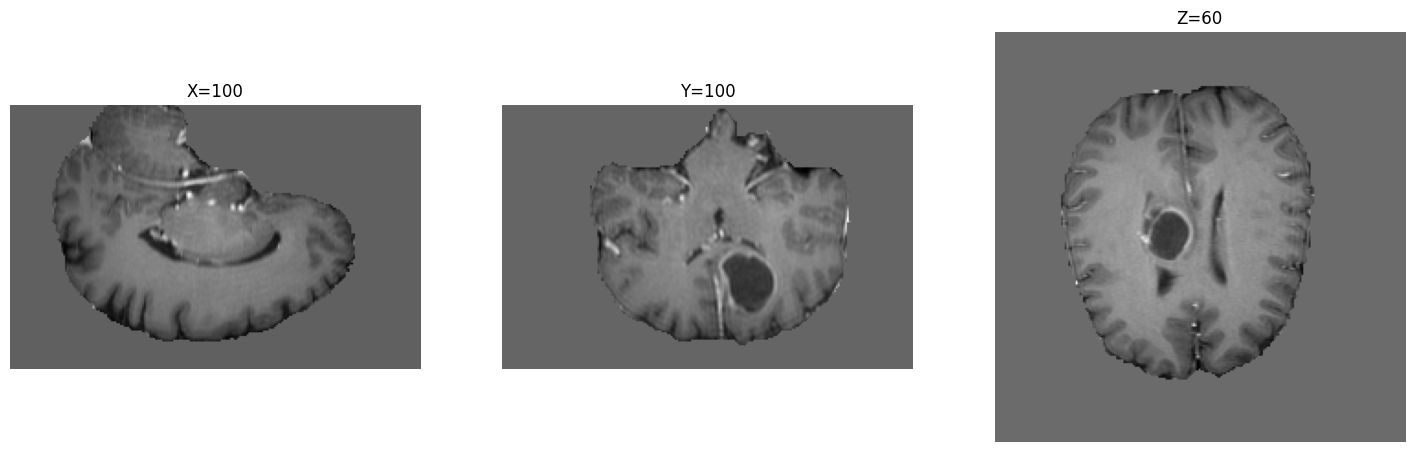

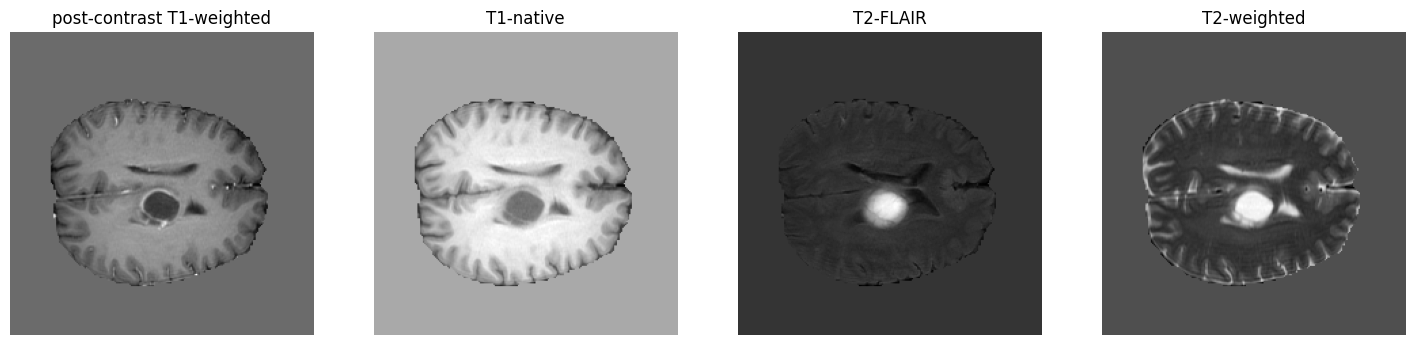

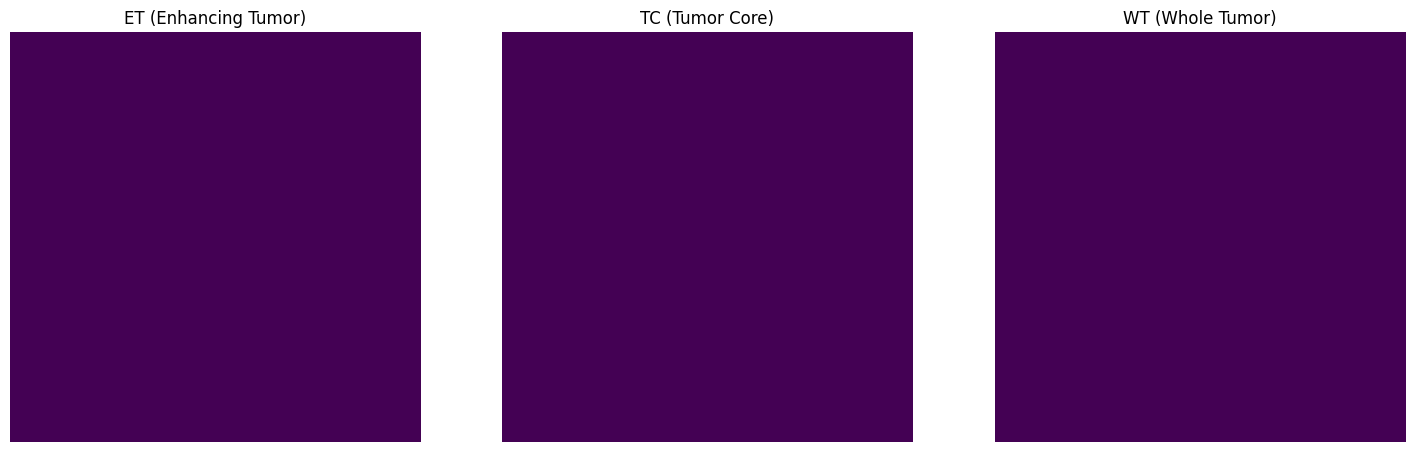

In [8]:
sample_ds = CacheDataset(train_data[:1], transform=train_transform, progress=False)
print(f"Input image shape: {sample_ds[0]['image'].shape}")
print(f"Input label shape: {sample_ds[0]['label'].shape}")
plot_input_output(sample_ds[0])

In [9]:
if _isColab:
    saved_path = os.path.join(_base_path, 'saved')
    reports_path = os.path.join(_base_path, 'reports')
    preds_path = os.path.join(_base_path, 'predictions')
    if not os.path.isdir(saved_path):
        os.mkdir(saved_path)
    if not os.path.isdir(reports_path):
        os.mkdir(reports_path)
    if not os.path.isdir(preds_path):
        os.mkdir(preds_path)
else:
    saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
    reports_path = os.path.join(_base_path, _config.get('REPORTS_FOLDER'))
    preds_path = os.path.join(_base_path, _config.get('PREDS_FOLDER'))

max_epochs = 200
val_interval = 1
device = 'cpu' #get_device()
model = SegResNet(init_filters=16, in_channels=4, out_channels=3, dropout_prob=0.2).to(device)

In [10]:
## NOTE: uncomment to execute the training phase.

# train_metrics = training_model(
# 	model = model,
# 	data = [train_data, eval_data],
# 	transforms = [train_transform, eval_transform, post_trans],
# 	epochs = max_epochs,
# 	val_interval = val_interval,
# 	device = device,
# 	paths = [saved_path, reports_path]
# )

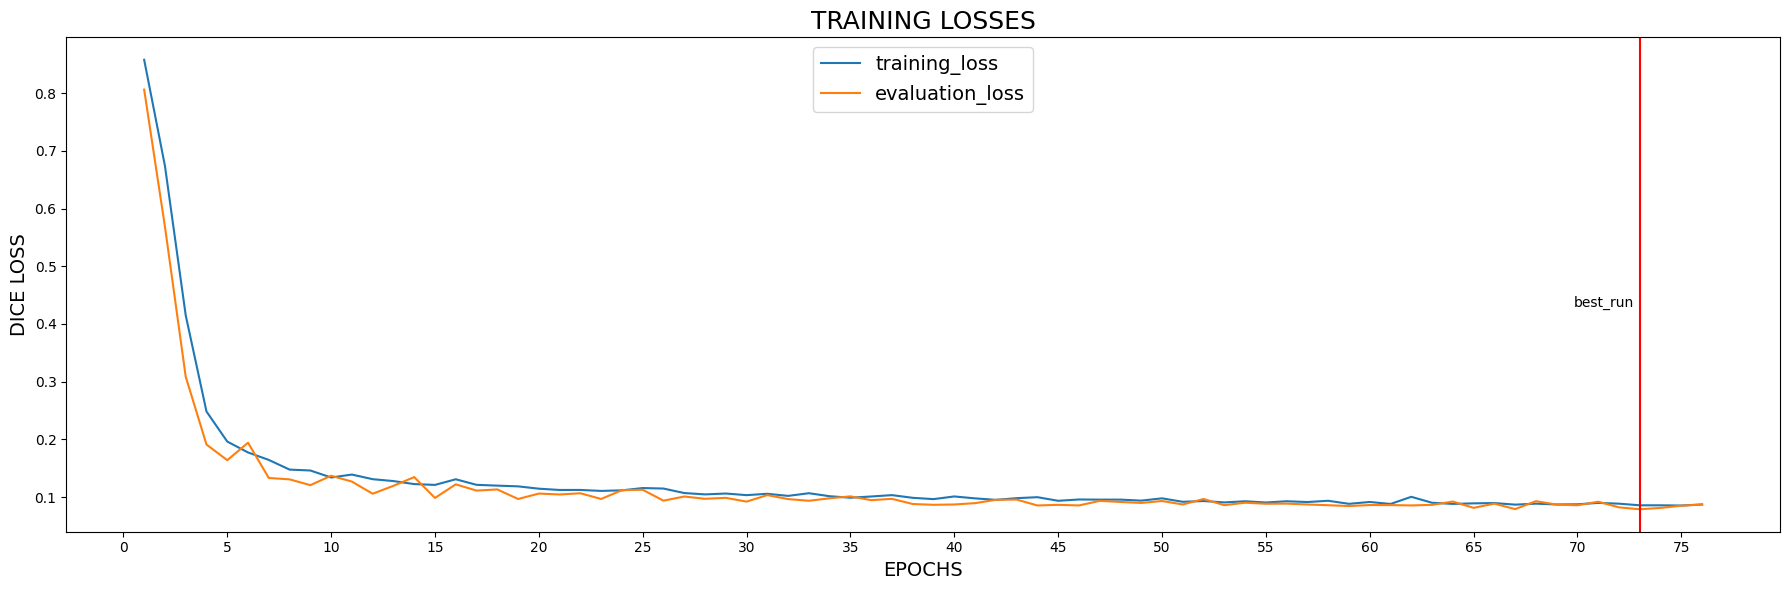

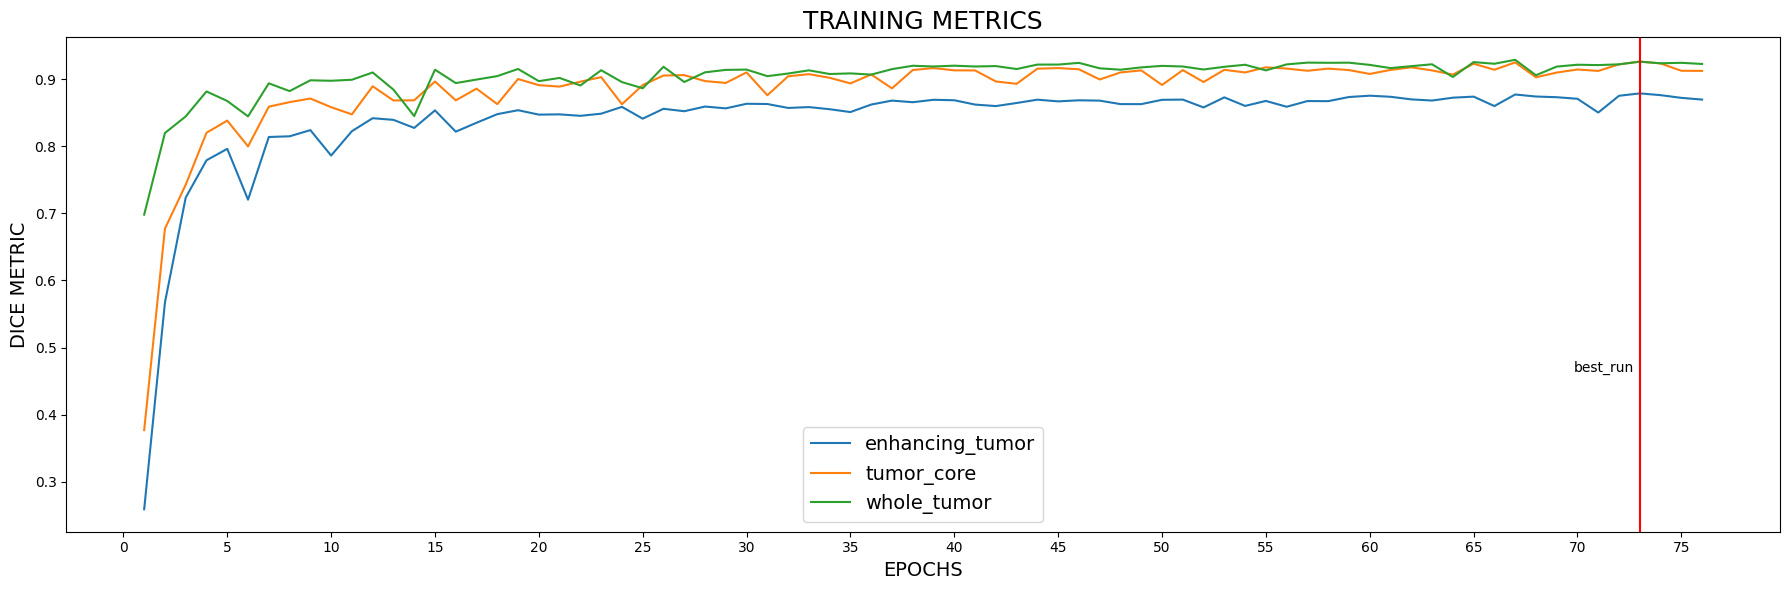

In [11]:
plot_training_values(model_name='SegResNet', folder=reports_path)

In [12]:
model = SegResNet(init_filters=16, in_channels=4, out_channels=3, dropout_prob=0.2).to(device)
samples, test_metrics = predict_model(
	model = model,
	data = test_data,
	transforms = [test_transform, post_test_transforms],
	device = device,
	paths = [saved_path, reports_path, preds_path],
	num_workers=0,
	write_to_file=True
)

inference 1/5


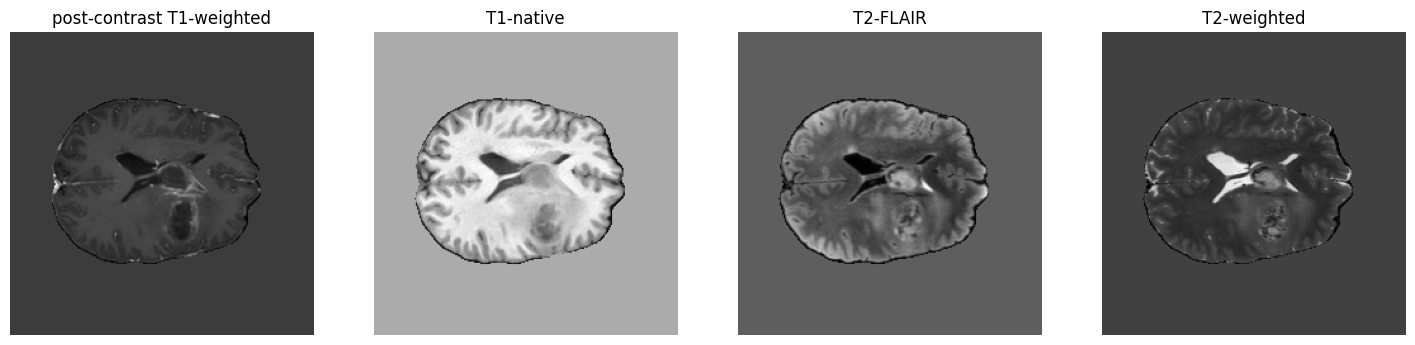

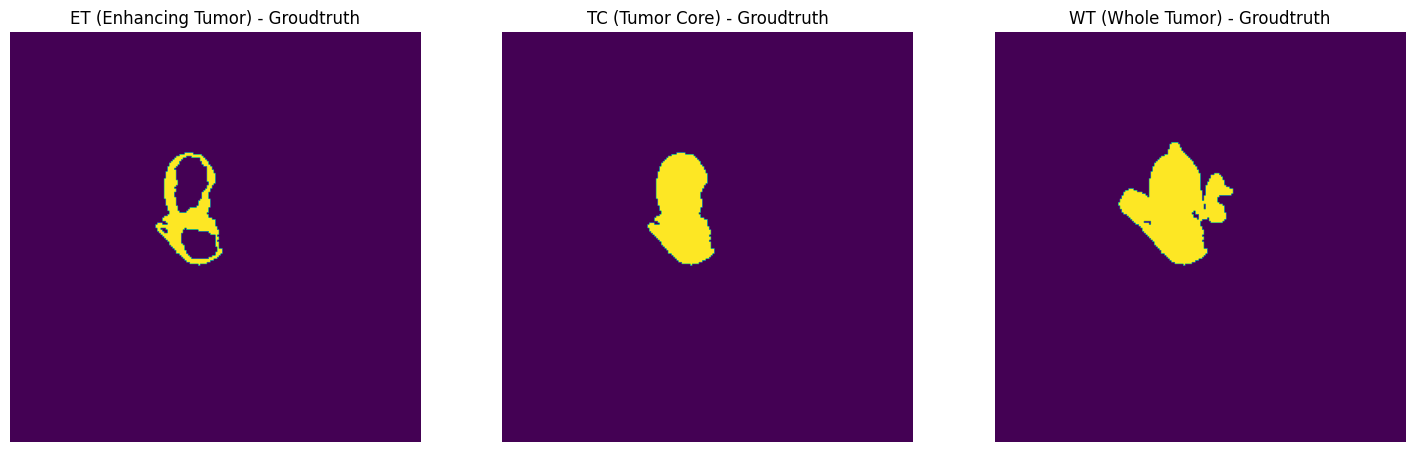

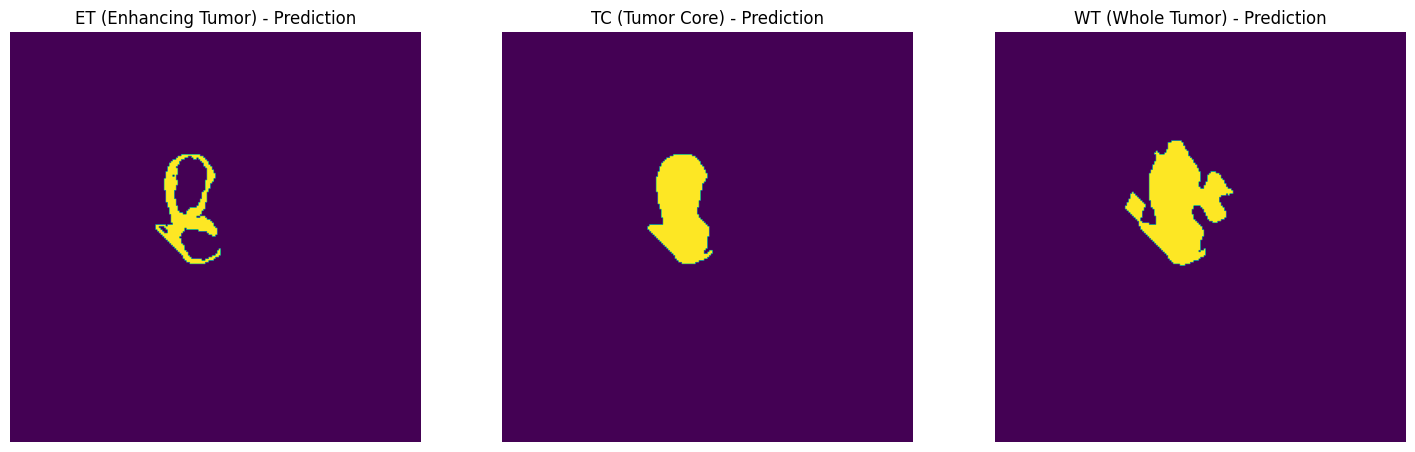

In [17]:
plot_prediction(samples[1])

In [33]:
dice, hausdorff = test_metrics
print(''.join(['> ' for i in range(40)]))
print(f'\n{"":<20}{"ET":<20}{"TC":<20}{"WT":<20}\n')
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Dice Score":<20}{dice[0]:<20.4f}{dice[1]:<20.4f}{dice[0]:<20.4f}\n')
print(f'{"Hausdorff[95%]":<20}{hausdorff[0]:<20.4f}{hausdorff[1]:<20.4f}{hausdorff[2]:<20.4f}\n')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    ET                  TC                  WT                  

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Dice Score          0.8263              0.8197              0.8263              

Hausdorff[95%]      2.8522              4.5716              4.2293              

